In [47]:
from igraph import *

import networkx as nx
from networkx.convert_matrix import _generate_weighted_edges

import scipy as sp
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import requests
import pickle
import json
import copy
import csv
import os
import re

from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [4]:
sdg_data = pd.read_excel('SDR-2022-database.xlsx')

In [5]:
sdg_pearson_data = sdg_data.corr(method='pearson')
sdg_spearman_data = sdg_data.corr(method='spearman')

In [6]:
sdg_goals = {}
sdg_temp = []
for item in sdg_pearson_data:
    if item.startswith('Goal '):
        sdg_goals[item] = []
        sdg_temp.append(item)
    if item.startswith('n_sdg'):
        n_sdg = item[5:7]
        goal_number = re.sub('[^0-9]', '', n_sdg)
        sdg_goals[f'Goal {goal_number} Score'].append(item)

sdg_sub_goals = {}
for k, v in sdg_goals.items():
    for x in v:
        sdg_sub_goals.setdefault(x,[]).append(k)

sdg_goals_names = list(sdg_goals.keys())
sdg_sub_goals_names = list(sdg_sub_goals.keys())

In [7]:
sdg_pearson = sdg_pearson_data[list(sdg_goals.keys())]
sdg_pearson = sdg_pearson.loc[list(sdg_goals.keys())]

sdg_spearman = sdg_spearman_data[list(sdg_goals.keys())]
sdg_spearman = sdg_spearman.loc[list(sdg_goals.keys())]

In [30]:
values = abs(sdg_pearson.values)
graph_sdg_p = Graph.Weighted_Adjacency(values.tolist())
graph_sdg_p = graph_sdg_p.simplify()
graph_sdg_p.es['weight'] = values[values.nonzero()]
graph_sdg_p.vs['label'] = sdg_goals_names
graph_sdg_p = graph_sdg_p.to_networkx().to_undirected()

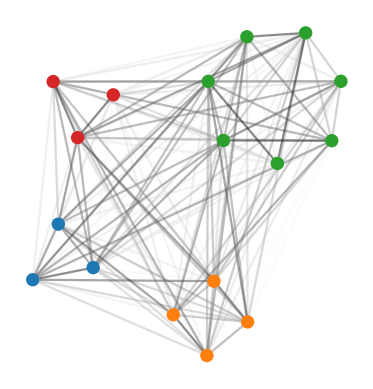

In [36]:
from community import community_louvain
import netgraph as ng

values = abs(sdg_pearson.values)
graph_sdg = Graph.Weighted_Adjacency(values.tolist())
graph_sdg = graph_sdg.simplify()
graph_sdg.es['weight'] = values[values.nonzero()]
graph_sdg.vs['label'] = sdg_goals_names
graph_sdg = graph_sdg.to_networkx().to_undirected()

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}

graph_sdg_clusters_nx = community_louvain.best_partition(graph_sdg)
node_color_1 = {node: community_to_color[community_id] for node, community_id in graph_sdg_clusters_nx.items()}
ng.Graph(graph_sdg,
    node_color=node_color_1, node_edge_width=0, edge_alpha=0.5,
    node_layout='community', node_layout_kwargs=dict(node_to_community=graph_sdg_clusters_nx)
)

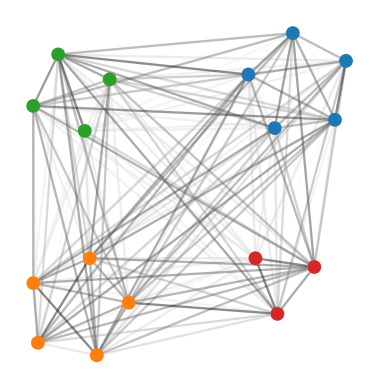

In [37]:
values = abs(sdg_spearman.values)
graph_sdg = Graph.Weighted_Adjacency(values.tolist())
graph_sdg = graph_sdg.simplify()
graph_sdg.es['weight'] = values[values.nonzero()]
graph_sdg.vs['label'] = sdg_goals_names
graph_sdg = graph_sdg.to_networkx().to_undirected()

graph_sdg_clusters_nx = community_louvain.best_partition(graph_sdg)
node_color_1 = {node: community_to_color[community_id] for node, community_id in graph_sdg_clusters_nx.items()}
ng.Graph(graph_sdg,
    node_color=node_color_1, node_edge_width=0, edge_alpha=0.5,
    node_layout='community', node_layout_kwargs=dict(node_to_community=graph_sdg_clusters_nx)
)

In [29]:
frames = range(38, 87)
window_size = 20

In [38]:
groupings = []
for frame in frames:
    data = sdg_data.loc[(sdg_data['SDG Index Score'] >= frame - window_size) & (sdg_data['SDG Index Score'] <= frame + window_size)]
    corr_data = data.corr(method='spearman')
    
    corr = corr_data[list(sdg_goals.keys())]
    corr = corr.loc[list(sdg_goals.keys())]

    values = abs(corr.values)
    graph_tmp = Graph.Weighted_Adjacency(values.tolist())
    graph_tmp = graph_tmp.simplify()
    graph_tmp.es['weight'] = values[values.nonzero()]
    graph_tmp.vs['label'] = sdg_goals_names
    graph_tmp = graph_tmp.to_networkx().to_undirected()

    graph_clusters = community_louvain.best_partition(graph_tmp)
    groupings.append(graph_clusters)

In [54]:
keys = graph_sdg_clusters_nx.keys()
groups = {0: [], 1: [], 2: [], 3: []}
for key, value in graph_sdg_clusters_nx.items():
    groups[value].append(key)

groups
# for frame_data in groupings:
#     for key in keys:
#         groups[key].append(frame_data[key])

{0: [1, 3, 6, 8, 13], 1: [0, 2, 4, 9, 11], 2: [5, 7, 12, 15], 3: [10, 14, 16]}

In [51]:
with open('groupings.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in groups.items():
       writer.writerow([key, value])